In [ ]:
+from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


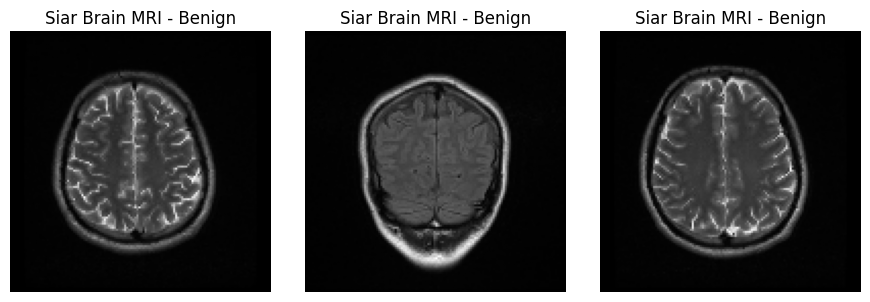

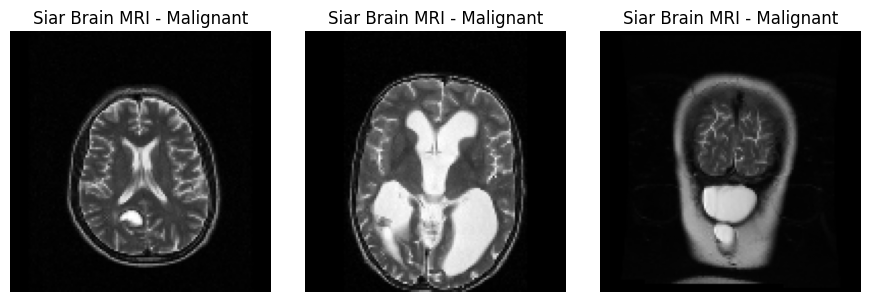

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Dataset 2 Paths (Benign and Malignant)
dataset2_benign = '/content/drive/MyDrive/siar/Siar-dataset/Normal'
dataset2_malignant = '/content/drive/MyDrive/siar/Siar-dataset/Tumor'

# Function to load and display sample images
def show_sample_images(folder, label, dataset_name, num_images=3):
    images_shown = 0
    plt.figure(figsize=(num_images * 3, 3))
    for i, filename in enumerate(os.listdir(folder)):
        if images_shown >= num_images:
            break
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            plt.subplot(1, num_images, images_shown + 1)
            plt.imshow(img, cmap='gray')
            plt.title(f"{dataset_name} - {label}")
            plt.axis('off')
            images_shown += 1
    plt.tight_layout()
    plt.show()

# Load Dataset 2 Images and Normalize
def load_and_normalize_images(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img = img.astype('float32') / 255.0  # Normalize to [0, 1]
            images.append(img)
    return images

# Load and normalize the images for Dataset 2
images2_benign = load_and_normalize_images(dataset2_benign)  # Load benign images
images2_malignant = load_and_normalize_images(dataset2_malignant)  # Load malignant images


# Display sample images for Dataset 2
show_sample_images(dataset2_benign, "Benign", "Siar Brain MRI")
show_sample_images(dataset2_malignant, "Malignant", "Siar Brain MRI")

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Prepare Data
X2 = np.array(images2_benign + images2_malignant).reshape(-1, 128, 128, 1)
y2 = ['benign'] * len(images2_benign) + ['malignant'] * len(images2_malignant)

# Encode and preprocess labels
le = LabelEncoder()
y2_encoded = le.fit_transform(y2)
y2_categorical = to_categorical(y2_encoded)

# Train-Test Split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2_categorical, test_size=0.2, random_state=42, stratify=y2_categorical)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

def create_cnn_model_with_upsampling(input_shape=(128, 128, 1)):
    model = Sequential()

    # Downsampling
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))  # 64x64

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))  # 32x32

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))  # 16x16

    # Upsampling path
    model.add(UpSampling2D((2, 2)))  # 32x32
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))

    model.add(UpSampling2D((2, 2)))  # 64x64
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))

    model.add(UpSampling2D((2, 2)))  # 128x128
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))0

    # Flatten and Dense layers for classification
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))  # 2 classes: Benign, Malignant

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create and view summary
model = create_cnn_model_with_upsampling()
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    33,554,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,744,370 (128.72 MB)

 Trainable params: 33,744,370 (128.72 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model on Dataset 2
from keras.callbacks import EarlyStopping


history2 = model.fit(
    X_train2, y_train2,
    epochs=20,
    batch_size=32,
    validation_data=(X_test2, y_test2)
)

Epoch 1/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9921 - loss: 0.0177 - val_accuracy: 0.9915 - val_loss: 0.0376
Epoch 2/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9963 - loss: 0.0121 - val_accuracy: 0.9859 - val_loss: 0.0491
Epoch 3/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9951 - loss: 0.0151 - val_accuracy: 0.9880 - val_loss: 0.0355
Epoch 4/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9921 - loss: 0.0228 - val_accuracy: 0.9781 - val_loss: 0.0706
Epoch 5/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9892 - loss: 0.0314 - val_accuracy: 0.9894 - val_loss: 0.0457
Epoch 6/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9927 - loss: 0.0213 - val_accuracy: 0.9958 - val_loss: 0.0165
Epoch 7/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9938 - loss: 0.0181 - val_accuracy: 0.9944 - val_loss: 0.0144
Epoch 8/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9952 - loss: 0.0147 - val_

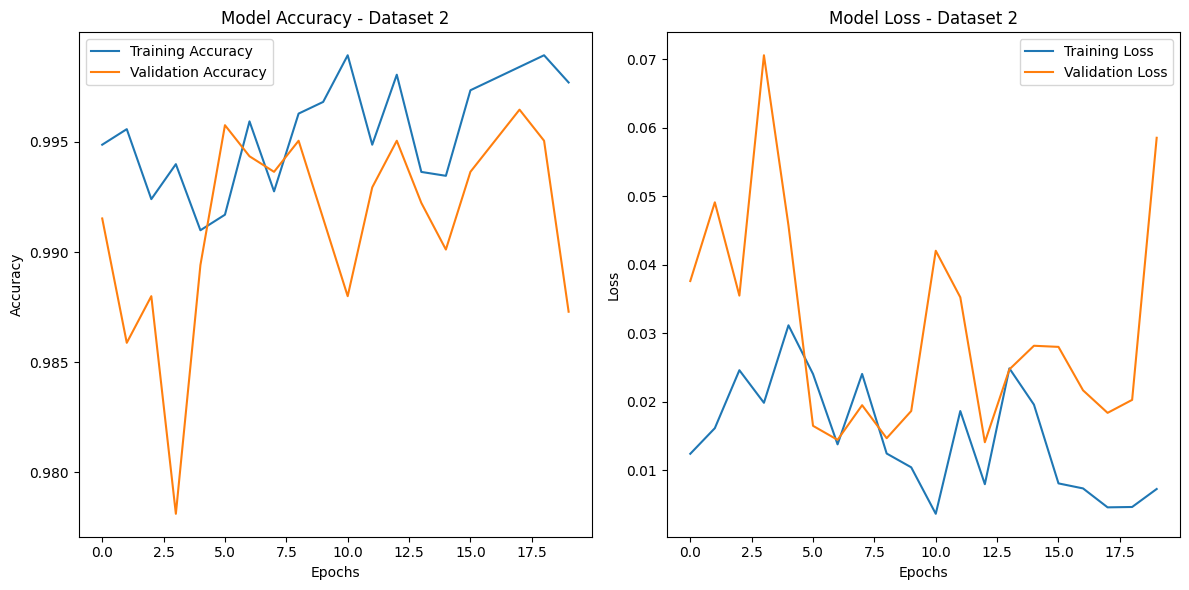

In [ ]:
# Plotting the accuracy and loss for Dataset 2
plt.figure(figsize=(12, 6))

# Accuracy Graph for Dataset 2
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy - Dataset 2')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Graph for Dataset 2
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss - Dataset 2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Evaluate the model on Dataset 2
y_pred2 = model.predict(X_test2)
y_pred2_classes = np.argmax(y_pred2, axis=1)  # Convert to class labels (0 or 1)

y_true2 = np.argmax(y_test2, axis=1)  # Ground truth labels (0 or 1)


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


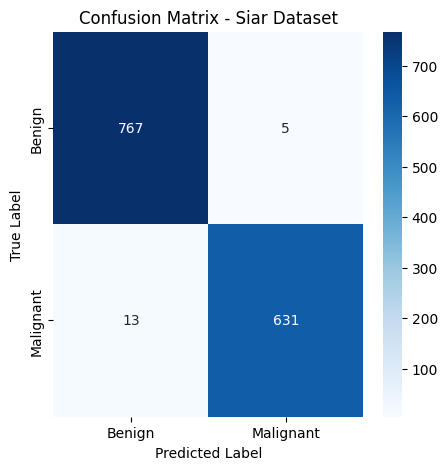

In [ ]:
# Confusion Matrix for Dataset 2
cm2 = confusion_matrix(y_true2, y_pred2_classes)
plot_confusion_matrix(cm2, classes=['Benign', 'Malignant'], title='Confusion Matrix - Siar Dataset')

In [ ]:
# Classification Report for Dataset 2
print("Classification Report - Dataset 2")
print(classification_report(y_true2, y_pred2_classes, target_names=['Benign', 'Malignant']))


Classification Report - Dataset 2
              precision    recall  f1-score   support

      Benign       0.98      0.99      0.99       772
   Malignant       0.99      0.98      0.99       644

    accuracy                           0.99      1416
   macro avg       0.99      0.99      0.99      1416
weighted avg       0.99      0.99      0.99      1416



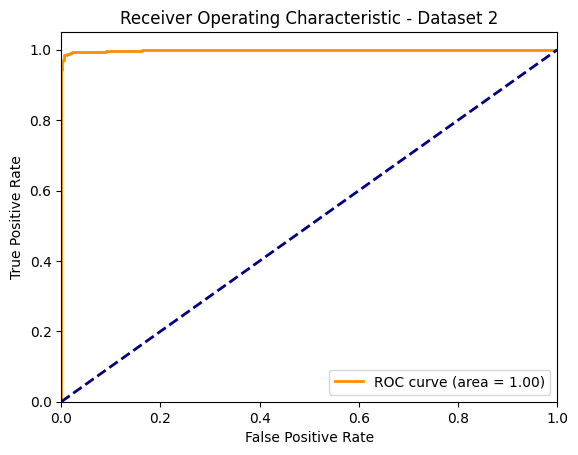

In [ ]:
# ROC Curve for Dataset 2
fpr2, tpr2, thresholds2 = roc_curve(y_true2, y_pred2[:, 1])  # Use the probabilities for class 1 (Malignant)
roc_auc2 = auc(fpr2, tpr2)

plt.figure()
plt.plot(fpr2, tpr2, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc2:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Dataset 2')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Path to the image you want to test
image_path = '/content/drive/MyDrive/siar/Siar-dataset/Tumor/Tumor (1012).jpg' # Replace with your image path

# Load and preprocess the image
img_to_test = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if img_to_test is not None:
    img_to_test = cv2.resize(img_to_test, (128, 128))
    img_to_test = img_to_test.astype('float32') / 255.0  # Normalize to [0, 1]
    img_to_test = np.expand_dims(img_to_test, axis=0)  # Add batch dimension
    img_to_test = np.expand_dims(img_to_test, axis=-1) # Add channel dimension

    # Make a prediction
    prediction = model.predict(img_to_test)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class = le.inverse_transform([predicted_class_index])[0]

    print(f"The predicted class for the image is: {predicted_class}")

else:
    print(f"Could not load image from {image_path}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
The predicted class for the image is: malignant
